# Glottolog stats dashboard
## report stats, monitor change

record properties of ``treedb.sqlite3``
loaded from [Glottolog](https://glottolog.org)
[master repo](https://github.com/glottolog/glottolog) commit
and monitor changes by diffing this

<div style="text-align: right">
  <a href="https://nbviewer.jupyter.org/github/glottolog/treedb/blob/master/Stats.ipynb">
      latest version from GitHub in nbviewer
  </a>
</div>

### Contents
1. [Clone the data repository](#Clone-the-data-repository)
2. [Use the repository root as source](#Use-the-repository-root-as-source)
3. [Set the database file and load it](#Set-the-database-file-and-load-it)
4. [Check the database](#Check-the-database)
5. [treedb.sqlite3](#treedb.sqlite3)
6. [print_dataset()](#print_dataset())
7. [\_\_dataset\_\_](#__dataset__)
8. [\_\_producer\_\_](#__producer__)
9. [treedb.raw](#treedb.raw)
10. [languoid](#languoid)
11. [macroarea](#macroarea)
12. [country](#country)
13. [altname](#altname)
14. [source](#source)
15. [classification](#classification)
16. [link](#link)
17. [endangerment](#endangerment)
18. [Example query](#example-query)

In [1]:
%matplotlib inline

import collections
import os

os.environ['SQLALCHEMY_WARN_20'] = 'true'

import pandas as pd
import sqlalchemy as sa
import matplotlib as mpl
import matplotlib.pyplot as plt

import treedb
import treedb.raw

treedb.configure_logging(log_sql=False)

treedb.print_versions()

treedb version: 2.6.4.dev0
pycountry version: 24.6.1
sqlalchemy version: 2.0.41
sqlite_version: 3.49.2
csv23 version: 0.3.4


## Clone the data repository

In [2]:
%%time

GLOTTOLOG_TAG = 'v5.1'

TARGET = '../glottolog/'

treedb.checkout_or_clone(GLOTTOLOG_TAG, target=TARGET)

CPU times: total: 0 ns
Wall time: 44 s


(CompletedProcess(args=['git', 'clone', '-c', 'advice.detachedHead=false', '--single-branch', '--branch', 'v5.1', '--depth', '1', 'https://github.com/glottolog/glottolog.git', WindowsPath('../glottolog')], returncode=0),
 CompletedProcess(args=['git', 'checkout', '-B', 'treedb', 'v5.1'], returncode=0))

In [3]:
treedb.glottolog_version()

GlottologVersion(commit='4ffdd9865810885b4675551040b93282b26dcf72', describe='v5.1')

## Use the repository root as source

In [4]:
treedb.set_root(TARGET)

<treedb._proxies.PathProxy path='../glottolog/languoids/tree' inode=25051272927591111>

In [5]:
next(treedb.iterfiles())

FileInfo(path=('abin1243',), dentry=<DirEntry 'md.ini'>, config=<treedb.languoids.files.ConfigParser object at 0x000001ADDA710050>)

In [6]:
dict(treedb.iterlanguoids(limit=1))

{('abin1243',): {'id': 'abin1243',
  'parent_id': None,
  'name': 'Abinomn',
  'level': 'language',
  'hid': 'bsa',
  'iso639_3': 'bsa',
  'latitude': -2.92281,
  'longitude': 138.891,
  'macroareas': ['Papunesia'],
  'countries': [{'id': 'ID', 'name': 'Indonesia'}],
  'links': [{'url': 'https://endangeredlanguages.com/lang/1763',
    'title': 'Abinomn',
    'scheme': 'https'},
   {'url': 'https://en.wikipedia.org/wiki/Abinomn_language',
    'title': None,
    'scheme': 'https'},
   {'url': 'https://www.wikidata.org/entity/Q56648',
    'title': None,
    'scheme': 'https'}],
  'timespan': None,
  'sources': {'glottolog': [{'bibfile': 'cldf',
     'bibkey': 'hammarstroem:17',
     'pages': None,
     'trigger': None},
    {'bibfile': 'cldf',
     'bibkey': 'lewis:ed:09',
     'pages': None,
     'trigger': None},
    {'bibfile': 'cldf', 'bibkey': 'np:nd:264', 'pages': None, 'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'e:Lagerberg:Moegip',
     'pages': None,
     'trigger': N

In [7]:
%time treedb.checksum(source='files')

CPU times: total: 23.2 s
Wall time: 2min 38s


'path_languoid:path:sha256:e37d43e99deb5fb5055916b29c009c43fafffc2c60c4e9fc027b34d16336d856'

## Set the database file and load it

In [8]:
treedb.set_engine('treedb.sqlite3')

<treedb._proxies.SQLiteEngineProxy filename='treedb.sqlite3' size=None>

In [9]:
%%time

engine = treedb.load(rebuild=False, exclude_raw=False)
engine

0:00:43.182771
CPU times: total: 42.5 s
Wall time: 43.5 s


<treedb._proxies.SQLiteEngineProxy filename='treedb.sqlite3' size=77860864>

## Check the database

In [10]:
engine.file_mtime()

datetime.datetime(2025, 5, 25, 21, 9, 13, 101506)

In [11]:
engine.file_size(as_megabytes=True)

74.25390625

In [12]:
%time engine.file_sha256()

CPU times: total: 62.5 ms
Wall time: 54.2 ms


'5fd99ce81a808f3d66361d5c1af52e4cdcff563d9abe314e389af85f3ffe4c72'

In [13]:
%time treedb.raw.checksum()

CPU times: total: 93.8 ms
Wall time: 88.7 ms


'strong:sha256:67e84364cca2eb6ce221777c3a3b965862b0231e841e20a3c8b65a50b3c68e31'

In [14]:
%time treedb.raw.checksum(weak=True)

CPU times: total: 3.64 s
Wall time: 3.64 s


'weak:sha256:8637e556a46c3a75fe726bb0d2ed4791770b5939f0ba1146a9457d4ad5b19b37'

In [15]:
%time treedb.checksum(source='tables')

CPU times: total: 4.52 s
Wall time: 4.53 s


'path_languoid:path:sha256:e37d43e99deb5fb5055916b29c009c43fafffc2c60c4e9fc027b34d16336d856'

In [16]:
%time treedb.checksum(source='raw')

CPU times: total: 7.44 s
Wall time: 7.45 s


'path_languoid:path:sha256:e37d43e99deb5fb5055916b29c009c43fafffc2c60c4e9fc027b34d16336d856'

In [17]:
%time treedb.check()

valid_pseudofamily_referencesCheck: OK
pseudofamilies_are_rootsCheck: OK
valid_glottocodeCheck: OK
valid_iso639_3Check: OK
valid_hidCheck: OK
clean_nameCheck: OK
family_parentCheck: OK
language_parentCheck: OK
dialect_parentCheck: OK
family_childrenCheck: OK
family_languagesCheck: OK
no_empty_filesCheck: OK
CPU times: total: 953 ms
Wall time: 959 ms


True

## treedb.sqlite3

In [18]:
treedb.configure_logging(level='INFO', log_sql=True)

treedb.scalar(sa.select(sa.func.sqlite_version()))

[INFO@treedb.logging_] treedb version: 2.6.4.dev0
BEGIN (implicit)
SELECT sqlite_version() AS sqlite_version_1
[generated in 0.00062s] ()
ROLLBACK


'3.49.2'

In [19]:
application_id = treedb.scalar(sa.text('PRAGMA application_id'))

assert application_id == 1122 == 0x462
assert application_id == sum(ord(c) for c in treedb.Dataset.__tablename__)
assert treedb.Dataset.__tablename__ == '__dataset__'

application_id

BEGIN (implicit)
PRAGMA application_id
[generated in 0.00109s] ()
ROLLBACK


1122

In [20]:
from treedb import pd_read_sql as read_sql

read_sql(treedb.select_tables_nrows(), index_col='table_name')

BEGIN (implicit)
SELECT sqlite_master.name 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name NOT LIKE ? ORDER BY sqlite_master.name
[generated in 0.00103s] ('table', 'sqlite_%')
ROLLBACK
[INFO@treedb.backend.pandas] pandas version: 2.2.3
BEGIN (implicit)
SELECT ? AS table_name, (SELECT count(*) AS n 
FROM __dataset__) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM __producer__) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _config) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _file) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _option) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _value) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM altname) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM altnameprovider) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM bibfile)

,n_rows
table_name,
__dataset__,1
__producer__,1
_config,402
_file,26953
_option,53
_value,660744
altname,160773
altnameprovider,11
bibfile,37


In [21]:
treedb.print_rows(treedb.backend.sqlite_master.select_views(),
                  format_='{name}')

BEGIN (implicit)
SELECT sqlite_master.name 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name NOT LIKE ? ORDER BY sqlite_master.name
[cached since 0.05234s ago] ('view', 'sqlite_%')
ROLLBACK


example
path_languoid
stats


In [22]:
from treedb import print_table_sql as print_sql

print_sql('sqlite_master')

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[generated in 0.00109s] ('table', 'sqlite_master')
SELECT count(*) AS n_rows 
FROM sqlite_master
[generated in 0.00041s] ()
ROLLBACK


None
66


## print_dataset()

In [23]:
treedb.print_dataset()

BEGIN (implicit)
SELECT __dataset__.id, __dataset__.title, __dataset__.git_commit, __dataset__.git_describe, __dataset__.clean, __dataset__.version, __dataset__.exclude_raw 
FROM __dataset__
[generated in 0.00089s] ()
SELECT __producer__.id, __producer__.name, __producer__.version 
FROM __producer__
[cached since 16.86s ago] ()
ROLLBACK
[INFO@treedb.backend.models] git describe 'v5.1' clean: True
[INFO@treedb.backend.models] __dataset__.git_commit: '4ffdd9865810885b4675551040b93282b26dcf72'
[INFO@treedb.backend.models] __dataset__.version: '5.1'
[INFO@treedb.backend.models] __producer__.name: treedb
[INFO@treedb.backend.models] __producer__.version: 2.6.4.dev0


git describe 'v5.1' clean: True
__dataset__.title: 'Glottolog treedb''
__dataset__.git_commit: '4ffdd9865810885b4675551040b93282b26dcf72'
__dataset__.version: '5.1'
__dataset__.exclude_raw: False
__producer__.name: treedb
__producer__.version: 2.6.4.dev0


## \_\_dataset\_\_

In [24]:
from treedb import Dataset

print_sql(Dataset)

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.01847s ago] ('table', '__dataset__')
SELECT count(*) AS n_rows 
FROM __dataset__
[generated in 0.00046s] ()
ROLLBACK


CREATE TABLE __dataset__ (
	id INTEGER NOT NULL CHECK (id = 1), 
	title TEXT NOT NULL CHECK (title != ''), 
	git_commit VARCHAR(40) NOT NULL CHECK (length(git_commit) = 40), 
	git_describe TEXT NOT NULL CHECK (git_describe != ''), 
	clean BOOLEAN NOT NULL, 
	version TEXT CHECK (version != ''), 
	exclude_raw BOOLEAN NOT NULL, 
	PRIMARY KEY (id), 
	UNIQUE (git_commit), 
	UNIQUE (git_describe), 
	CHECK (clean IN (0, 1)), 
	CHECK (exclude_raw IN (0, 1))
)
1


In [25]:
dataset, = treedb.iterrows(sa.select(Dataset), mappings=True)

pd.DataFrame.from_dict(dataset, orient='index',
                       columns=['__dataset__'])

BEGIN (implicit)
SELECT __dataset__.id, __dataset__.title, __dataset__.git_commit, __dataset__.git_describe, __dataset__.clean, __dataset__.version, __dataset__.exclude_raw 
FROM __dataset__
[cached since 0.01801s ago] ()
ROLLBACK


,__dataset__
id,1
title,Glottolog treedb
git_commit,4ffdd9865810885b4675551040b93282b26dcf72
git_describe,v5.1
clean,True
version,5.1
exclude_raw,False


## \_\_producer\_\_

In [26]:
from treedb import Producer

print_sql(Producer)

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.03491s ago] ('table', '__producer__')
SELECT count(*) AS n_rows 
FROM __producer__
[generated in 0.00042s] ()
ROLLBACK


CREATE TABLE __producer__ (
	id INTEGER NOT NULL CHECK (id = 1), 
	name TEXT NOT NULL CHECK (name != ''), 
	version TEXT NOT NULL CHECK (version != ''), 
	PRIMARY KEY (id), 
	UNIQUE (name)
)
1


In [27]:
producer, = treedb.iterrows(sa.select(Producer), mappings=True)

pd.DataFrame.from_dict(producer, orient='index',
                       columns=['__producer__'])

BEGIN (implicit)
SELECT __producer__.id, __producer__.name, __producer__.version 
FROM __producer__
[cached since 16.89s ago] ()
ROLLBACK


,__producer__
id,1
name,treedb
version,2.6.4.dev0


## `treedb.raw`

In [28]:
from treedb.raw import File, Option, Value

for model in (File, Option, Value):
    print_sql(model)

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.05074s ago] ('table', '_file')
SELECT count(*) AS n_rows 
FROM _file
[generated in 0.00039s] ()
ROLLBACK


CREATE TABLE _file (
	id INTEGER NOT NULL, 
	glottocode VARCHAR(8) NOT NULL CHECK (length(glottocode) = 8), 
	path TEXT NOT NULL CHECK (length(path) >= 8 AND (length(path) + 1) % 9 = 0), 
	size INTEGER NOT NULL CHECK (size > 0), 
	sha256 VARCHAR(64) NOT NULL CHECK (length(sha256) = 64), 
	PRIMARY KEY (id), 
	CHECK (substr(path, -length(glottocode)) = glottocode), 
	UNIQUE (glottocode), 
	UNIQUE (path), 
	UNIQUE (sha256)
)
26953


BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.05611s ago] ('table', '_option')
SELECT count(*) AS n_rows 
FROM _option
[generated in 0.00042s] ()
ROLLBACK


CREATE TABLE _option (
	id INTEGER NOT NULL, 
	section TEXT NOT NULL CHECK (section != ''), 
	option TEXT NOT NULL CHECK (option != ''), 
	is_lines BOOLEAN, 
	defined BOOLEAN NOT NULL, 
	defined_any_options BOOLEAN NOT NULL, 
	ord_section INTEGER CHECK (ord_section >= 1), 
	ord_option INTEGER CHECK (ord_section >= 0), 
	PRIMARY KEY (id), 
	UNIQUE (section, option), 
	CHECK ((is_lines IS NULL) = (defined = 0)), 
	CHECK (defined = 1 OR defined_any_options = 0), 
	CHECK ((defined = 0) = (ord_section IS NULL)), 
	CHECK (ord_section IS NOT NULL OR ord_option IS NULL), 
	CHECK (is_lines IN (0, 1)), 
	CHECK (defined IN (0, 1)), 
	CHECK (defined_any_options IN (0, 1))
)
53


BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.06037s ago] ('table', '_value')
SELECT count(*) AS n_rows 
FROM _value
[generated in 0.00046s] ()
ROLLBACK


CREATE TABLE _value (
	file_id INTEGER NOT NULL, 
	option_id INTEGER NOT NULL, 
	line INTEGER NOT NULL CHECK (line > 0), 
	value TEXT NOT NULL CHECK (value != ''), 
	PRIMARY KEY (file_id, option_id, line), 
	UNIQUE (file_id, line), 
	FOREIGN KEY(file_id) REFERENCES _file (id), 
	FOREIGN KEY(option_id) REFERENCES _option (id)
) WITHOUT ROWID
660744


In [29]:
read_sql(sa.select(File).limit(5), index_col='id')

BEGIN (implicit)
SELECT _file.id, _file.glottocode, _file.path, _file.size, _file.sha256 
FROM _file
 LIMIT ? OFFSET ?
[generated in 0.00090s] (5, 0)
ROLLBACK


,glottocode,path,size,sha256
id,,,,
1,abin1243,abin1243,1609,f9bfc07c0fa5c494f10120446ea774425e0228ff398041...
2,abis1238,abis1238,1980,74bfb186dac461a02c14c8222b9555c1565eb06c39c604...
3,abkh1242,abkh1242,306,5dd28ae1265a0967b1a236d06c7fd6e7ac3b9e32d866dd...
4,abkh1243,abkh1242/abkh1243,257,a5900355c69af22d94eaa0a147b95fc291270634bc033c...
5,abaz1241,abkh1242/abkh1243/abaz1241,2839,8ec3d57e891488e28613d8b7bdc03b004a4b9168313e0e...


In [30]:
read_sql(sa.select(Option).limit(5), index_col='id')

BEGIN (implicit)
SELECT _option.id, _option.section, _option.option, _option.is_lines, _option.defined, _option.defined_any_options, _option.ord_section, _option.ord_option 
FROM _option
 LIMIT ? OFFSET ?
[generated in 0.00084s] (5, 0)
ROLLBACK


,section,option,is_lines,defined,defined_any_options,ord_section,ord_option
id,,,,,,,
1,core,name,False,True,False,1,1
2,core,hid,False,True,False,1,2
3,core,level,False,True,False,1,3
4,core,iso639-3,False,True,False,1,4
5,core,latitude,False,True,False,1,5


In [31]:
read_sql(sa.select(Value).limit(5), index_col=['file_id', 'option_id'])

BEGIN (implicit)
SELECT _value.file_id, _value.option_id, _value.line, _value.value 
FROM _value
 LIMIT ? OFFSET ?
[generated in 0.00115s] (5, 0)
ROLLBACK


line     value
file_id option_id                
1       1             1   Abinomn
        2             2       bsa
        3             3  language
        4             4       bsa
        5             5  -2.92281

In [32]:
select_file_values = (sa.select(Option.section, Option.option, Value.line, Value.value)
                      .select_from(File)
                      .filter_by(glottocode=sa.bindparam('glottocode'))
                      .join(Value).join(Option))

read_sql(select_file_values, params={'glottocode': 'abin1243'},
         index_col=['section', 'option', 'line'])

BEGIN (implicit)
SELECT _option.section, _option.option, _value.line, _value.value 
FROM _file JOIN _value ON _file.id = _value.file_id JOIN _option ON _option.id = _value.option_id 
WHERE _file.glottocode = ?
[generated in 0.00081s] ('abin1243',)
ROLLBACK


value
section        option              line                                                   
core           name                1                                               Abinomn
               hid                 2                                                   bsa
               level               3                                              language
               iso639-3            4                                                   bsa
               latitude            5                                              -2.92281
               longitude           6                                               138.891
               macroareas          7                                             Papunesia
               countries           8                                                    ID
               links               9     [Abinomn](https://endangeredlanguages.com/lang...
                                   10       https://en.wikipedia.org/wiki/Abinomn_language
                                   11               https://www.wikidata.org/entity/Q56648
sources        glottolog           12                             **cldf:hammarstroem:17**
                                   13                                 **cldf:lewis:ed:09**
                                   14                                   **cldf:np:nd:264**
                                   15                            **hh:e:Lagerberg:Moegip**
                                   16                          **hh:h:SilzerClouse:Index**
                                   17                       **hh:h:SilzerHeikkinen:Irian**
                                   18                 **hh:hv:Foley:Northwest-New-Guinea**
                                   19               **hh:hvtyp:DonohueMusgrave:Melanesia**
                                   20                               **hh:w:Fiwei:Abinomn**
altnames       multitree           21                                               "Baso"
                                   22                                              Abinomn
                                   23                                             Avinomen
                                   24                                                 Foja
                                   25                                                 Foya
               lexvo               26                                         Abinomn [en]
                                   27                                Abinomn language [en]
                                   28                                       Abinomneg [br]
                                   29                                  Lingua abinomn [gl]
                                   30                                Llingua Abinomn [ast]
               hhbib_lgcode        31                                                 Baso
               elcat               32                                               "Baso"
                                   33                                              Abinomn
                                   34                                             Avinomen
                                   35                                                 Foja
                                   36                                                 Foya
triggers       lgcode              37                                         macrohistory
                                   38                                               moegip
identifier     multitree           39                                                  bsa
               endangeredlanguages 40                                                 1763
classification familyrefs          41                          **hh:h:SilzerClouse:Index**
                                   42               **hh:hvtyp:DonohueMusgrave:Melanesia**
endangerment   status              43                                       nearl

BEGIN (implicit)
SELECT floor((length(_file.path) + ?) / (? + 0.0)) AS path_depth, languoid.level, count(*) AS n_files 
FROM _file JOIN languoid ON _file.glottocode = languoid.id GROUP BY floor((length(_file.path) + ?) / (? + 0.0)), languoid.level ORDER BY path_depth, languoid.level
[generated in 0.00105s] (1, 9, 1, 9)
ROLLBACK


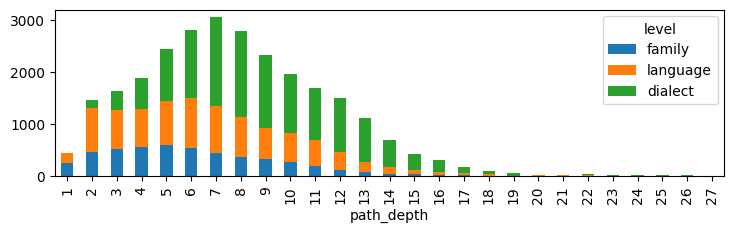

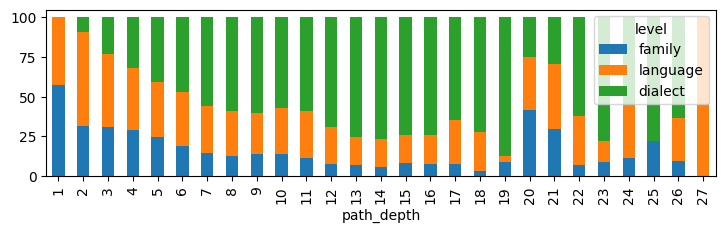

In [33]:
path_depth = File.path_depth()

select_path_depths = (sa.select(path_depth,
                                treedb.Languoid.level, sa.func.count().label('n_files'))
                      .join_from(File, treedb.Languoid, File.glottocode == treedb.Languoid.id)
                      .group_by(path_depth, treedb.Languoid.level)
                      .order_by('path_depth', 'level'))

_ = (read_sql(select_path_depths, index_col=['path_depth', 'level'])
     .unstack(fill_value=0).droplevel(0, axis='columns')[list(treedb.LEVEL)])

_.plot.bar(stacked=True, figsize=(12 * 72 / 100, 3 * 72 / 100))

(100 * _.div(_.sum(axis='columns'), axis='rows')).plot.bar(stacked=True, figsize=(12 * 72 / 100, 3 * 72 / 100));

BEGIN (implicit)
SELECT _file.size AS file_size, count(*) AS n_files 
FROM _file GROUP BY _file.size ORDER BY file_size
[generated in 0.00071s] ()
ROLLBACK


,count,min,max
file_size,3524.0,65.0,47211.0


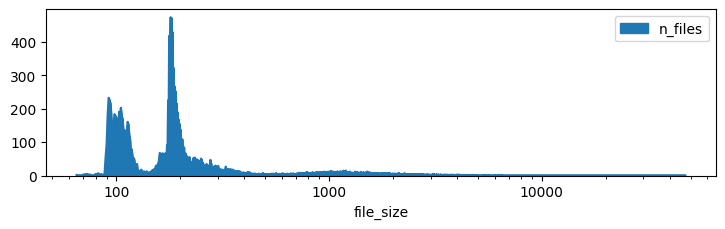

In [34]:
file_size = File.size.label('file_size')

select_file_sizes = (sa.select(file_size, sa.func.count().label('n_files'))
                     .group_by(file_size)
                     .order_by('file_size'))

_ = read_sql(select_file_sizes, index_col='file_size')

(_.plot.area(figsize=(12 * 72 / 100, 3 * 72 / 100), logx=True)
 .xaxis.set_major_formatter(mpl.ticker.ScalarFormatter()))
(_.index.to_series().describe()
 .to_frame().transpose()[['count', 'min', 'max']])

BEGIN (implicit)
SELECT file_nvalues.n_values, count(*) AS n_files 
FROM (SELECT _file.glottocode AS glottocode, count(DISTINCT _value.option_id) AS n_values 
FROM _file JOIN _value ON _file.id = _value.file_id GROUP BY _file.glottocode) AS file_nvalues GROUP BY file_nvalues.n_values ORDER BY file_nvalues.n_values
[generated in 0.00094s] ()
ROLLBACK


,count,min,max
n_values,36.0,2.0,37.0


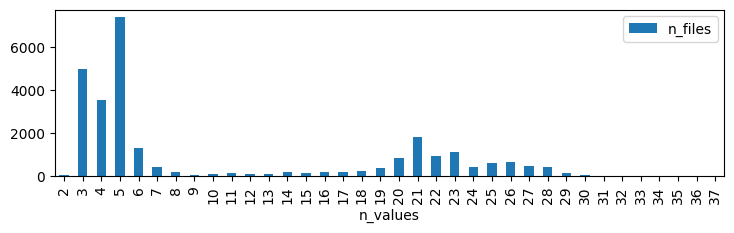

In [35]:
file_nvalues = (sa.select(File.glottocode,
                          sa.func.count(Value.option_id.distinct()).label('n_values'))
                .join_from(File, Value)
                .group_by(File.glottocode)
                .alias('file_nvalues')
                .c.n_values)

select_nvalues = (sa.select(file_nvalues, sa.func.count().label('n_files'))
                  .group_by(file_nvalues)
                  .order_by(file_nvalues))

_ = read_sql(select_nvalues, index_col='n_values')

_.plot.bar(figsize=(12 * 72 / 100, 3 * 72 / 100))
(_.index.to_series().describe()
 .to_frame().transpose()[['count', 'min', 'max']])

BEGIN (implicit)
SELECT length(_value.value) AS value_length, count(*) AS n_values 
FROM _value GROUP BY length(_value.value) ORDER BY value_length
[generated in 0.00094s] ()
ROLLBACK


,count,min,max
value_length,814.0,1.0,6215.0


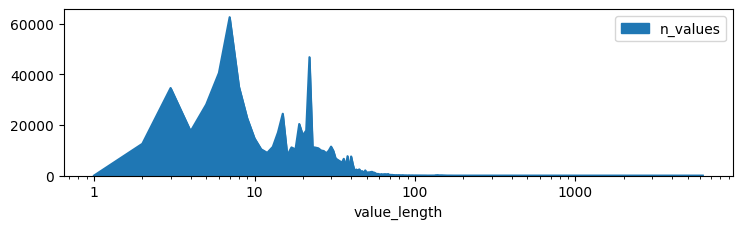

In [36]:
value_length = sa.func.length(Value.value).label('value_length')

select_value_length = (sa.select(value_length, sa.func.count().label('n_values'))
                       .group_by(value_length)
                       .order_by('value_length'))

_ = read_sql(select_value_length, index_col='value_length')

(_.plot.area(figsize=(12 * 72 / 100, 3 * 72 / 100), logx=True)
 .xaxis.set_major_formatter(mpl.ticker.ScalarFormatter()))
(_.index.to_series().describe()
 .to_frame().transpose()[['count', 'min', 'max']])

In [37]:
%time treedb.raw.print_stats()

[INFO@treedb.raw.export] fetch statistics
BEGIN (implicit)
SELECT _option.section, _option.option, count(*) AS n 
FROM _option JOIN _value ON _option.id = _value.option_id GROUP BY _option.section, _option.option ORDER BY _option.defined DESC, _option.ord_section, _option.ord_option, _option.section, n DESC, _option.option
[generated in 0.00092s] ()
ROLLBACK


core                   name                   26,953
core                   hid                    8,922
core                   level                  26,953
core                   iso639-3               8,167
core                   latitude               8,907
core                   longitude              8,907
core                   macroareas             22,127
core                   countries              11,912
core                   name_comment           14
core                   comment                1
core                   location               1
core                   name_pronunciation     1
core                   speakers               1
core                   links                  32,870
core                   timespan               1,058
sources                glottolog              220,672
altnames               multitree              54,469
altnames               hhbib_lgcode           40,639
altnames               lexvo                  26,035
altnames             

## languoid

In [38]:
from treedb import Languoid

print_sql(Languoid)

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 3.322s ago] ('table', 'languoid')
SELECT count(*) AS n_rows 
FROM languoid
[generated in 0.00054s] ()
ROLLBACK


CREATE TABLE languoid (
	id VARCHAR(8) NOT NULL CHECK (length(id) = 8), 
	name VARCHAR NOT NULL CHECK (name != ''), 
	level VARCHAR NOT NULL, 
	parent_id VARCHAR(8), 
	hid TEXT CHECK (length(hid) >= 3), 
	iso639_3 VARCHAR(3) CHECK (length(iso639_3) = 3), 
	latitude FLOAT CHECK (latitude BETWEEN -90 AND 90), 
	longitude FLOAT CHECK (longitude BETWEEN -180 AND 180), 
	PRIMARY KEY (id), 
	CHECK ((latitude IS NULL) = (longitude IS NULL)), 
	UNIQUE (name), 
	FOREIGN KEY(level) REFERENCES languoidlevel (name), 
	FOREIGN KEY(parent_id) REFERENCES languoid (id) DEFERRABLE INITIALLY DEFERRED, 
	UNIQUE (hid), 
	UNIQUE (iso639_3)
) WITHOUT ROWID
26953


In [39]:
from treedb import LEVEL
from treedb.models import LanguoidLevel

FAMILY, LANGUAGE, DIALECT = LEVEL

print_sql(LanguoidLevel)
read_sql(sa.select(LanguoidLevel).order_by('ordinal'), index_col='name')

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 3.336s ago] ('table', 'languoidlevel')
SELECT count(*) AS n_rows 
FROM languoidlevel
[generated in 0.00036s] ()
ROLLBACK


CREATE TABLE languoidlevel (
	name VARCHAR NOT NULL CHECK (name != ''), 
	description TEXT NOT NULL CHECK (description != ''), 
	ordinal INTEGER NOT NULL CHECK (ordinal >= 1), 
	PRIMARY KEY (name)
) WITHOUT ROWID
3


BEGIN (implicit)
SELECT languoidlevel.name, languoidlevel.description, languoidlevel.ordinal 
FROM languoidlevel ORDER BY languoidlevel.ordinal
[generated in 0.00077s] ()
ROLLBACK


,description,ordinal
name,,
family,sub-grouping of languoids above the language l...,1
language,defined by mutual non-intellegibility,2
dialect,any variety which is not a language,3


In [40]:
from treedb.models import PseudoFamily

print_sql(PseudoFamily)
read_sql(sa.select(PseudoFamily).order_by('name'), index_col='config_section')

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 3.349s ago] ('table', 'pseudofamily')
SELECT count(*) AS n_rows 
FROM pseudofamily
[generated in 0.00043s] ()
ROLLBACK


CREATE TABLE pseudofamily (
	languoid_id VARCHAR(8) NOT NULL, 
	name VARCHAR NOT NULL, 
	config_section VARCHAR NOT NULL CHECK (config_section != ''), 
	description TEXT CHECK (description != ''), 
	bookkeeping BOOLEAN CHECK (bookkeeping = 1), 
	PRIMARY KEY (languoid_id), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	UNIQUE (name), 
	FOREIGN KEY(name) REFERENCES languoid (name), 
	UNIQUE (config_section), 
	UNIQUE (bookkeeping)
) WITHOUT ROWID
8


BEGIN (implicit)
SELECT pseudofamily.languoid_id, pseudofamily.name, pseudofamily.config_section, pseudofamily.description, pseudofamily.bookkeeping 
FROM pseudofamily ORDER BY pseudofamily.name
[generated in 0.00075s] ()
ROLLBACK


,languoid_id,name,description,bookkeeping
config_section,,,,
artificial_language,arti1236,Artificial Language,A language known to have been created by consc...,None
bookkeeping,book1242,Bookkeeping,An alleged language that has been replaced wit...,True
mixed_language,mixe1287,Mixed Language,None,None
pidgin,pidg1258,Pidgin,A language used for interethnic communication ...,None
sign_language,sign1238,Sign Language,A language with visible manual signs as the mo...,None
speech_register,spee1234,Speech Register,A language not used by a community of speakers...,None
unattested,unat1236,Unattested,A language arguably different from all other e...,None
unclassifiable,uncl1493,Unclassifiable,A language arguably different from all other e...,None


In [41]:
%time treedb.print_languoid_stats()

BEGIN (implicit)
WITH RECURSIVE tree(parent_id, child_id) AS 
(SELECT root.id AS parent_id, root.id AS child_id 
FROM languoid AS root 
WHERE root.parent_id IS NULL UNION ALL SELECT tree.parent_id AS parent_id, child.id AS child_id 
FROM tree JOIN languoid AS child ON tree.child_id = child.parent_id)
 SELECT ? AS kind, count(*) AS n 
FROM languoid UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? AND languoid.parent_id IS NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? AND languoid.parent_id IS NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.parent_id IS NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? AND languoid.parent_id IS NOT NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? UNION ALL SELECT ? AS kind, count(*) AS n 
FROM

26,953 languoids
   247 families
   183 isolates
   430 roots
 8,605 languages
 4,547 subfamilies
13,554 dialects
 7,667 Spoken L1 Languages
   227 Sign Language
   120 Unclassifiable
    87 Pidgin
    68 Unattested
    31 Artificial Language
     8 Mixed Language
    15 Speech Register


ROLLBACK


 8,223 All
   382 Bookkeeping
CPU times: total: 484 ms
Wall time: 460 ms


In [42]:
read_sql(sa.select(Languoid).limit(5), index_col='id')

BEGIN (implicit)
SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid
 LIMIT ? OFFSET ?
[generated in 0.00109s] (5, 0)
ROLLBACK


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
3adt1234,3Ad-Tekles,dialect,nort3292,None,None,NaN,NaN
aala1237,Aalawa,dialect,ramo1244,None,None,NaN,NaN
aant1238,Aantantara,dialect,nort2920,None,None,NaN,NaN
aari1238,Aari-Gayil,family,ahkk1235,aiz,aiz,NaN,NaN
aari1239,Aari,language,aari1238,aiw,aiw,5.95034,36.5721


In [43]:
read_sql(sa.select(Languoid).order_by('id').limit(5), index_col='id')

BEGIN (implicit)
SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.id
 LIMIT ? OFFSET ?
[generated in 0.00093s] (5, 0)
ROLLBACK


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
3adt1234,3Ad-Tekles,dialect,nort3292,None,None,NaN,NaN
aala1237,Aalawa,dialect,ramo1244,None,None,NaN,NaN
aant1238,Aantantara,dialect,nort2920,None,None,NaN,NaN
aari1238,Aari-Gayil,family,ahkk1235,aiz,aiz,NaN,NaN
aari1239,Aari,language,aari1238,aiw,aiw,5.95034,36.5721


In [44]:
read_sql(sa.select(Languoid).order_by('name').limit(5), index_col='id')

BEGIN (implicit)
SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.name
 LIMIT ? OFFSET ?
[generated in 0.00114s] (5, 0)
ROLLBACK


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
gane1238,!Gã!ne,language,east2867,NOCODE_Gane,None,-31.3200,28.7500
oung1238,!O!ung,language,book1242,oun,oun,-15.3000,14.3500
kwii1241,!Ui,family,tuuu1241,None,None,NaN,NaN
abda1238,'Abd Al-Kuri,dialect,soqo1240,None,None,12.1959,52.2282
aden1242,'Aden,dialect,jude1267,None,None,NaN,NaN


In [45]:
Child, Parent = (sa.orm.aliased(Languoid, name=n) for n in ('child', 'parent'))

select_parent_levels = (sa.select(Child.level.label('child_level'),
                                  Parent.level.label('parent_level'),
                                  sa.func.count().label('n_languoids'))
                        .outerjoin_from(Child, Parent, Child.parent_id == Parent.id)
                        .group_by(Child.level, Parent.level)
                        .order_by('child_level', 'parent_level'))

(read_sql(select_parent_levels, index_col=['child_level', 'parent_level'])
 .unstack(fill_value=0).assign(all=lambda x: x.sum(axis='columns'))
 .pipe(lambda x: pd.concat([x, x.sum().rename('all').to_frame().T.rename_axis('child_level')])))

BEGIN (implicit)
SELECT child.level AS child_level, parent.level AS parent_level, count(*) AS n_languoids 
FROM languoid AS child LEFT OUTER JOIN languoid AS parent ON child.parent_id = parent.id GROUP BY child.level, parent.level ORDER BY child_level, parent_level
[generated in 0.00086s] ()
ROLLBACK


n_languoids                            all
parent_level         NaN dialect family language       
child_level                                            
dialect                0    2556      0    10998  13554
family               247       0   4547        0   4794
language             183       0   8422        0   8605
all                  430    2556  12969    10998  26953

In [46]:
select_lang_nisos = (sa.select(Languoid.level.label('level'),
                              sa.func.count().label('n_languoids'),
                              sa.func.count(Languoid.iso639_3).label('n_isos'))
                    .group_by(Languoid.level)
                    .order_by('level'))

(read_sql(select_lang_nisos, index_col='level')
 .assign(ratio=lambda x: 100 * x['n_isos'] / x['n_languoids']))

BEGIN (implicit)
SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.iso639_3) AS n_isos 
FROM languoid GROUP BY languoid.level ORDER BY level
[generated in 0.00080s] ()
ROLLBACK


,n_languoids,n_isos,ratio
level,,,
dialect,13554,269,1.984654
family,4794,45,0.938673
language,8605,7853,91.260895


In [47]:
select_lang_nlocations = (sa.select(Languoid.level.label('level'),
                                    sa.func.count().label('n_languoids'),
                                    sa.func.count(Languoid.latitude).label('n_locations'))
                          .group_by(Languoid.level)
                          .order_by('level'))

(read_sql(select_lang_nlocations, index_col='level')
 .assign(ratio=lambda x: 100 * x['n_locations'] / x['n_languoids']))

BEGIN (implicit)
SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.latitude) AS n_locations 
FROM languoid GROUP BY languoid.level ORDER BY level
[generated in 0.00098s] ()
ROLLBACK


,n_languoids,n_locations,ratio
level,,,
dialect,13554,580,4.279180
family,4794,36,0.750939
language,8605,8291,96.350959


BEGIN (implicit)
SELECT languoid.latitude, languoid.longitude 
FROM languoid 
WHERE languoid.level = ?
[generated in 0.00094s] ('language',)
ROLLBACK


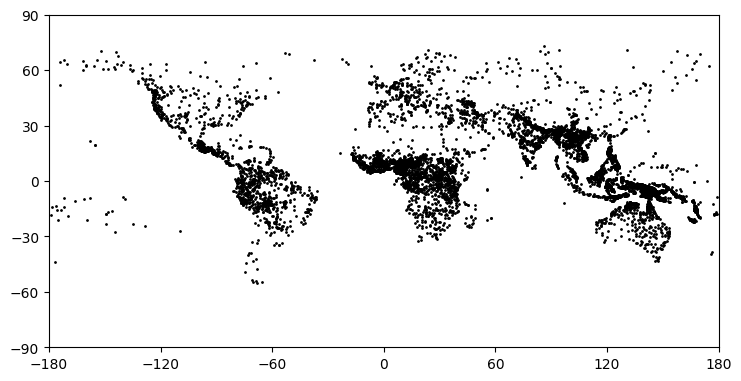

In [48]:
select_latlon = (sa.select(Languoid.latitude, Languoid.longitude)
                 .select_from(Languoid)
                 .filter_by(level=LANGUAGE))

latitudes, longitudes = zip(*treedb.iterrows(select_latlon))
    
plt.figure(figsize=(12 * 72 / 100, 6 * 72 / 100))
plt.axis([-180, 180, -90, 90])
plt.xticks(range(-180, 181, 60))
plt.yticks(range(-90, 91, 30))
plt.scatter(longitudes, latitudes, 1, 'black');

BEGIN (implicit)
WITH RECURSIVE tree(parent_id, child_id) AS 
(SELECT root.id AS parent_id, child.id AS child_id 
FROM languoid AS root LEFT OUTER JOIN languoid AS child ON root.id = child.parent_id 
WHERE root.parent_id IS NULL AND root.level = ? UNION ALL SELECT tree.parent_id AS parent_id, child.id AS child_id 
FROM tree JOIN languoid AS child ON tree.child_id = child.parent_id)
 SELECT root.id AS family_id, count(child.id) AS n_languages 
FROM tree JOIN languoid AS root ON tree.parent_id = root.id LEFT OUTER JOIN languoid AS child ON tree.child_id = child.id 
WHERE child.level = ? GROUP BY root.id 
HAVING count(child.id) >= ? ORDER BY n_languages
[generated in 0.00112s] ('family', 'language', 100)
ROLLBACK


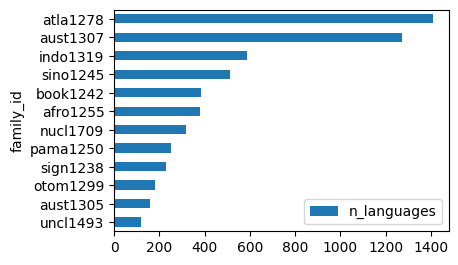

In [49]:
Family, Child, family_child = treedb.Languoid.parent_descendant(parent_root=True,
                                                                parent_level=FAMILY)

n_languages = sa.func.count(Child.id).label('n_languages')

select_family_nlanguages = (sa.select(Family.id.label('family_id'), n_languages)
                            .select_from(family_child)
                            .where(Child.level == LANGUAGE)
                            .group_by(Family.id))

select_top_families = (select_family_nlanguages
                       .having(n_languages >= 100)
                       .order_by('n_languages'))

(read_sql(select_top_families, index_col='family_id')
 .plot.barh(figsize=(6 * 72 / 100, 4 * 72 / 100)));

BEGIN (implicit)
WITH RECURSIVE tree(parent_id, child_id) AS 
(SELECT root.id AS parent_id, child.id AS child_id 
FROM languoid AS root LEFT OUTER JOIN languoid AS child ON root.id = child.parent_id 
WHERE root.parent_id IS NULL AND root.level = ? UNION ALL SELECT tree.parent_id AS parent_id, child.id AS child_id 
FROM tree JOIN languoid AS child ON tree.child_id = child.parent_id)
 SELECT family_nlanguages.n_languages AS family_size, count(*) AS n_families 
FROM (SELECT root.id AS family_id, count(child.id) AS n_languages 
FROM tree JOIN languoid AS root ON tree.parent_id = root.id LEFT OUTER JOIN languoid AS child ON tree.child_id = child.id 
WHERE child.level = ? GROUP BY root.id) AS family_nlanguages GROUP BY family_nlanguages.n_languages ORDER BY family_size
[generated in 0.00099s] ('family', 'language')
ROLLBACK


,count,min,max
family_size,58.0,2.0,1410.0


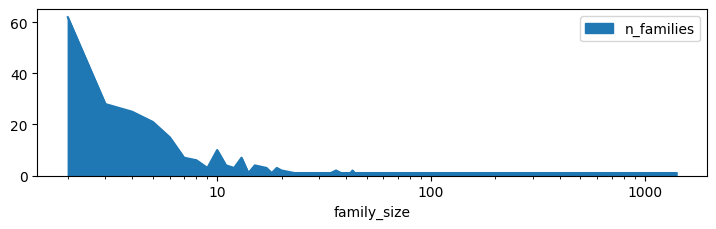

In [50]:
family_size = (select_family_nlanguages
               .alias('family_nlanguages')
               .c.n_languages.label('family_size'))

select_family_sizes = (sa.select(family_size, sa.func.count().label('n_families'))
                       .group_by(family_size)
                       .order_by('family_size'))

_ = read_sql(select_family_sizes, index_col='family_size')

(_.plot.area(figsize=(12 * 72 / 100, 3 * 72 / 100), logx=True)
 .xaxis.set_major_formatter(mpl.ticker.ScalarFormatter()))
(_.index.to_series().describe()
 .to_frame().transpose()[['count', 'min', 'max']])

In [51]:
levels = (sa.union_all(*[sa.select(sa.literal(l).label('level')) for l in LEVEL])
          .cte(name='levels'))

select_parent_nchildren = (sa.select(Parent.id.label('parent_id'),
                                     Parent.level.label('parent_level'),
                                     levels.c.level.label('child_level'),
                                     sa.func.count(Child.id).label('n_children'))
                           .join_from(Parent, levels, sa.true())
                           .outerjoin(Child, sa.and_(Parent.id == Child.parent_id, 
                                                     Child.level == levels.c.level))
                           .group_by(Parent.id, Parent.level, levels.c.level))

(read_sql(select_parent_nchildren)
 .pivot_table(index='parent_level', columns='child_level', values='n_children',
              aggfunc=['sum', 'max', 'mean'], fill_value=0))

BEGIN (implicit)
WITH levels AS 
(SELECT ? AS level UNION ALL SELECT ? AS level UNION ALL SELECT ? AS level)
 SELECT parent.id AS parent_id, parent.level AS parent_level, levels.level AS child_level, count(child.id) AS n_children 
FROM languoid AS parent JOIN levels ON 1 = 1 LEFT OUTER JOIN languoid AS child ON parent.id = child.parent_id AND child.level = levels.level GROUP BY parent.id, parent.level, levels.level
[generated in 0.00089s] ('family', 'language', 'dialect')
ROLLBACK


sum                     max                      mean  \
child_level  dialect family language dialect family language   dialect   
parent_level                                                             
dialect         2556      0        0      22      0        0  0.188579   
family             0   4547     8422       0     47      372  0.000000   
language       10998      0        0      32      0        0  1.278094   

                                  
child_level     family  language  
parent_level                      
dialect       0.000000  0.000000  
family        0.948477  1.756779  
language      0.000000  0.000000

In [52]:
Parent, Child, parent_child = treedb.Languoid.parent_descendant()

select_parent_ndescendants = (sa.select(Parent.id.label('parent_id'),
                                        Parent.level.label('parent_level'),
                                        sa.func.count(Child.id).label('n_descendants'))
                              .select_from(parent_child)
                              .group_by(Parent.id, Parent.level)
                              .alias('parent_ndescendants'))

parent_level = select_parent_ndescendants.c.parent_level

n_descendants = select_parent_ndescendants.c.n_descendants

d_min = sa.func.min(n_descendants).label('min')
d_max = sa.func.max(n_descendants).label('max')
d_mean = (sa.func.sum(n_descendants).cast(sa.Float) / sa.func.count(n_descendants)).label('mean')

select_level_mean_descendants = (sa.select(parent_level, d_min, d_max, d_mean)
                                 .group_by(parent_level)
                                 .order_by(parent_level))

select_total_mean_descendants = sa.select(sa.literal('total').label('parent_level'),
                                          d_min, d_max, d_mean)

select_mean_descendants = [select_level_mean_descendants, select_total_mean_descendants]

_ = pd.concat([read_sql(q, index_col='parent_level') for q in select_mean_descendants])
_.columns = pd.MultiIndex.from_product([['n_descendants'], _.columns])
_

BEGIN (implicit)
WITH RECURSIVE tree(parent_id, child_id) AS 
(SELECT parent.id AS parent_id, child.id AS child_id 
FROM languoid AS parent LEFT OUTER JOIN languoid AS child ON parent.id = child.parent_id UNION ALL SELECT tree.parent_id AS parent_id, child.id AS child_id 
FROM tree JOIN languoid AS child ON tree.child_id = child.parent_id)
 SELECT parent_ndescendants.parent_level, min(parent_ndescendants.n_descendants) AS min, max(parent_ndescendants.n_descendants) AS max, CAST(sum(parent_ndescendants.n_descendants) AS FLOAT) / (count(parent_ndescendants.n_descendants) + 0.0) AS mean 
FROM (SELECT parent.id AS parent_id, parent.level AS parent_level, count(child.id) AS n_descendants 
FROM tree JOIN languoid AS parent ON tree.parent_id = parent.id LEFT OUTER JOIN languoid AS child ON tree.child_id = child.id GROUP BY parent.id, parent.level) AS parent_ndescendants GROUP BY parent_ndescendants.parent_level ORDER BY parent_ndescendants.parent_level
[generated in 0.00095s] ()
ROLLBACK
BEGI

n_descendants                 
                       min   max       mean
parent_level                               
dialect                  0    56   0.257784
family                   1  4852  34.488319
language                 0   119   1.575131
total                    0  4852   6.766779

## macroarea

In [53]:
from treedb.models import Macroarea, languoid_macroarea

print_sql(Macroarea)
print_sql(languoid_macroarea)
read_sql(sa.select(Macroarea).order_by('name'), index_col='config_section')

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 6.275s ago] ('table', 'macroarea')
SELECT count(*) AS n_rows 
FROM macroarea
[generated in 0.00059s] ()
ROLLBACK


CREATE TABLE macroarea (
	name VARCHAR NOT NULL CHECK (name != ''), 
	config_section VARCHAR NOT NULL CHECK (config_section != ''), 
	description TEXT NOT NULL CHECK (description != ''), 
	PRIMARY KEY (name), 
	UNIQUE (config_section)
) WITHOUT ROWID
6


BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 6.28s ago] ('table', 'languoid_macroarea')
SELECT count(*) AS n_rows 
FROM languoid_macroarea
[generated in 0.00046s] ()
ROLLBACK


CREATE TABLE languoid_macroarea (
	languoid_id VARCHAR(8) NOT NULL, 
	macroarea_name VARCHAR NOT NULL, 
	PRIMARY KEY (languoid_id, macroarea_name), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	FOREIGN KEY(macroarea_name) REFERENCES macroarea (name)
) WITHOUT ROWID
22127


BEGIN (implicit)
SELECT macroarea.name, macroarea.config_section, macroarea.description 
FROM macroarea ORDER BY macroarea.name
[generated in 0.00073s] ()
ROLLBACK


,name,description
config_section,,
africa,Africa,The continent
australia,Australia,The continent
eurasia,Eurasia,The Eurasian landmass North of Sinai. Includes...
northamerica,North America,North and Middle America up to Panama. Include...
pacific,Papunesia,"All islands between Sumatra and the Americas, ..."
southamerica,South America,Everything South of Darién.


BEGIN (implicit)
SELECT macroarea.name AS macroarea, count(*) AS n_languages 
FROM macroarea LEFT OUTER JOIN languoid_macroarea ON macroarea.name = languoid_macroarea.macroarea_name JOIN languoid ON languoid.id = languoid_macroarea.languoid_id 
WHERE languoid.level = ? GROUP BY macroarea.name ORDER BY n_languages DESC
[generated in 0.00097s] ('language',)
ROLLBACK


,n_languages
macroarea,
Africa,2375
Papunesia,2215
Eurasia,2023
North America,793
South America,718
Australia,389


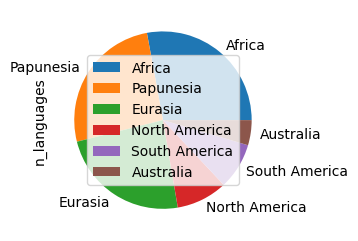

In [54]:
select_macroarea_nlanguages = (sa.select(Macroarea.name.label('macroarea'),
                                         sa.func.count().label('n_languages'))
                               .outerjoin_from(Macroarea, languoid_macroarea).join(Languoid)
                               .filter_by(level=LANGUAGE)
                               .group_by(Macroarea.name)
                               .order_by(sa.desc('n_languages')))

_ = read_sql(select_macroarea_nlanguages, index_col='macroarea')
_.plot.pie(y='n_languages', figsize=(6 * 72 / 100, 4 * 72 / 100))
_

In [55]:
macroareas = sa.func.group_concat(Macroarea.name, ', ').label('macroareas')

select_multiarea_languages = (sa.select(Languoid.id, Languoid.name, macroareas)
                              .select_from(Languoid)
                              .filter_by(level=LANGUAGE)
                              .join(languoid_macroarea).join(Macroarea)
                              .group_by(Languoid.id)
                              .having(sa.func.count() > 1)
                              .order_by('id'))
    
assert read_sql(select_multiarea_languages).empty

BEGIN (implicit)
SELECT languoid.id, languoid.name, group_concat(macroarea.name, ?) AS macroareas 
FROM languoid JOIN languoid_macroarea ON languoid.id = languoid_macroarea.languoid_id JOIN macroarea ON macroarea.name = languoid_macroarea.macroarea_name 
WHERE languoid.level = ? GROUP BY languoid.id 
HAVING count(*) > ? ORDER BY languoid.id
[generated in 0.00084s] (', ', 'language', 1)
ROLLBACK


## country

In [56]:
from treedb.models import Country, languoid_country

print_sql(Country)
print_sql(languoid_country)

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 6.424s ago] ('table', 'country')
SELECT count(*) AS n_rows 
FROM country
[generated in 0.00036s] ()
ROLLBACK


CREATE TABLE country (
	id VARCHAR(2) NOT NULL CHECK (length(id) = 2), 
	name TEXT NOT NULL CHECK (name != ''), 
	PRIMARY KEY (id), 
	UNIQUE (name)
) WITHOUT ROWID
246


BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 6.429s ago] ('table', 'languoid_country')
SELECT count(*) AS n_rows 
FROM languoid_country
[generated in 0.00053s] ()
ROLLBACK


CREATE TABLE languoid_country (
	languoid_id VARCHAR(8) NOT NULL, 
	country_id VARCHAR(2) NOT NULL, 
	PRIMARY KEY (languoid_id, country_id), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	FOREIGN KEY(country_id) REFERENCES country (id)
) WITHOUT ROWID
11912


In [57]:
select_country_nlanguages = (sa.select(Country.name.label('country'),
                                       sa.func.count().label('n_languages'))
                             .outerjoin_from(Country, languoid_country).join(Languoid)
                             .filter_by(level=LANGUAGE)
                             .group_by(Country.id)
                             .order_by(sa.desc('n_languages'))
                             .limit(10))

read_sql(select_country_nlanguages, index_col='country')

BEGIN (implicit)
SELECT country.name AS country, count(*) AS n_languages 
FROM country LEFT OUTER JOIN languoid_country ON country.id = languoid_country.country_id JOIN languoid ON languoid.id = languoid_country.languoid_id 
WHERE languoid.level = ? GROUP BY country.id ORDER BY n_languages DESC
 LIMIT ? OFFSET ?
[generated in 0.00088s] ('language', 10, 0)
ROLLBACK


,n_languages
country,
Papua New Guinea,899
Indonesia,752
Nigeria,590
India,518
China,448
Australia,401
Mexico,339
Brazil,338
United States,321


In [58]:
select_lang_country = (sa.select(Languoid.id, Languoid.name, Country.id.label('country'))
                       .select_from(Languoid)
                       .filter_by(level=LANGUAGE)
                       .join(languoid_country).join(Country)
                       .order_by(Languoid.id, 'country')
                       .alias('lang_country'))

countries = sa.func.group_concat(select_lang_country.c.country, ', ').label('countries')

select_multicountry_languages = (sa.select(select_lang_country.c.id,
                                           select_lang_country.c.name,
                                           sa.func.count().label('n_countries'),
                                           countries)
                                 .group_by(select_lang_country.c.id,
                                           select_lang_country.c.name)
                                 .having(sa.func.count() > 1)
                                 .order_by(sa.desc('n_countries'),
                                           select_lang_country.c.id)
                                 .limit(10))
    
read_sql(select_multicountry_languages, index_col='id')

BEGIN (implicit)
SELECT lang_country.id, lang_country.name, count(*) AS n_countries, group_concat(lang_country.country, ?) AS countries 
FROM (SELECT languoid.id AS id, languoid.name AS name, country.id AS country 
FROM languoid JOIN languoid_country ON languoid.id = languoid_country.languoid_id JOIN country ON country.id = languoid_country.country_id 
WHERE languoid.level = ? ORDER BY languoid.id, country) AS lang_country GROUP BY lang_country.id, lang_country.name 
HAVING count(*) > ? ORDER BY n_countries DESC, lang_country.id
 LIMIT ? OFFSET ?
[generated in 0.00109s] (', ', 'language', 1, 10, 0)
ROLLBACK


,name,n_countries,countries
id,,,
stan1293,English,34,"AU, BM, BR, BZ, CA, CC, CK, CU, CX, DO, FK, GB..."
vlax1238,Vlax Romani,32,"AL, AT, BA, BG, BY, CH, CZ, DE, ES, FI, FR, GR..."
balk1252,Balkan Romani,30,"AL, AT, BA, BG, BY, CH, CZ, DE, FI, FR, GB, GR..."
stan1288,Spanish,30,"AD, AR, BO, BR, BZ, CL, CO, CR, CU, DO, EC, ES..."
balt1257,Baltic Romani,29,"AL, AT, BA, BG, BY, CH, CZ, DE, EE, FI, FR, GB..."
sint1235,Sinte-Manus Romani,29,"AL, AT, BA, BG, BY, CH, CZ, DE, FI, FR, GB, GR..."
carp1235,Central Romani,28,"AL, AT, BA, BG, BY, CH, CZ, DE, FI, FR, GB, GR..."
stan1318,Standard Arabic,25,"AE, BH, DJ, DZ, EG, ER, IL, IQ, JO, KM, KW, LB..."
amer1248,American Sign Language,22,"BB, BF, BJ, BO, CA, CD, CF, CI, CN, GA, GH, JM..."


BEGIN (implicit)
SELECT language_ncountries.n_countries, count(*) AS n_languages 
FROM (SELECT languoid.id AS id, count(*) AS n_countries 
FROM languoid LEFT OUTER JOIN languoid_country ON languoid.id = languoid_country.languoid_id 
WHERE languoid.level = ? GROUP BY languoid.id) AS language_ncountries GROUP BY language_ncountries.n_countries ORDER BY language_ncountries.n_countries
[generated in 0.00093s] ('language',)
ROLLBACK
BEGIN (implicit)
SELECT ? AS value, count(*) AS count, sum(language_ncountries.n_countries) AS sum, min(language_ncountries.n_countries) AS min, max(language_ncountries.n_countries) AS max, avg(language_ncountries.n_countries) AS mean 
FROM (SELECT languoid.id AS id, count(*) AS n_countries 
FROM languoid LEFT OUTER JOIN languoid_country ON languoid.id = languoid_country.languoid_id 
WHERE languoid.level = ? GROUP BY languoid.id) AS language_ncountries
[generated in 0.00100s] ('n_countries', 'language')
ROLLBACK


,count,sum,min,max,mean
n_countries,8605,11342,1,34,1.318071


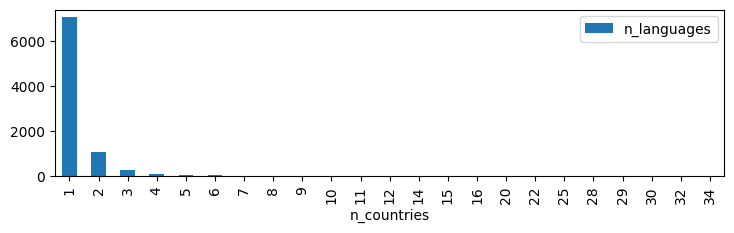

In [59]:
n_countries = (sa.select(Languoid.id, sa.func.count().label('n_countries'))
               .select_from(Languoid)
               .filter_by(level=LANGUAGE)
               .outerjoin(languoid_country)
               .group_by(Languoid.id)
               .alias('language_ncountries')
               .c.n_countries)

select_lc_dist = (sa.select(n_countries, sa.func.count().label('n_languages'))
                  .group_by(n_countries)
                  .order_by('n_countries'))

_ = read_sql(select_lc_dist, index_col='n_countries')

_.plot.bar(figsize=(12 * 72 / 100, 3 * 72 / 100))

(read_sql(sa.select(sa.literal('n_countries').label('value'),
                   sa.func.count().label('count'),
                   sa.func.sum(n_countries).label('sum'),
                   sa.func.min(n_countries).label('min'),
                   sa.func.max(n_countries).label('max'),
                   sa.func.avg(n_countries).label('mean')),
          index_col='value')
 .rename_axis(None))

## altname

BEGIN (implicit)
SELECT altnameprovider.name AS altname_provider, count(DISTINCT altname.languoid_id) AS n_languoids 
FROM altnameprovider JOIN altname ON altnameprovider.id = altname.provider_id GROUP BY altnameprovider.name ORDER BY n_languoids, altname_provider
[generated in 0.00103s] ()
ROLLBACK


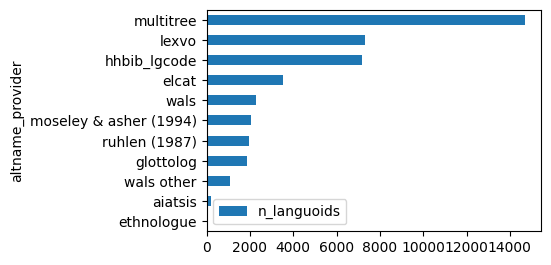

In [60]:
from treedb.models import Altname, AltnameProvider

select_provider_nlanguoids = (sa.select(AltnameProvider.name.label('altname_provider'),
                                        sa.func.count(sa.distinct(Altname.languoid_id)).label('n_languoids'))
                              .join_from(AltnameProvider, Altname)
                              .group_by(AltnameProvider.name)
                              .order_by('n_languoids', 'altname_provider'))

(read_sql(select_provider_nlanguoids, index_col='altname_provider')
 .plot.barh(figsize=(6 * 72 / 100, 4 * 72 / 100)));

BEGIN (implicit)
SELECT languoid_naltnames.n_altnames, count(*) AS n_languoids 
FROM (SELECT languoid.id AS id, count(*) AS n_altnames 
FROM languoid LEFT OUTER JOIN altname ON languoid.id = altname.languoid_id GROUP BY languoid.id) AS languoid_naltnames GROUP BY languoid_naltnames.n_altnames ORDER BY languoid_naltnames.n_altnames
[generated in 0.00091s] ()
ROLLBACK
BEGIN (implicit)
SELECT ? AS value, count(*) AS count, sum(languoid_naltnames.n_altnames) AS sum, min(languoid_naltnames.n_altnames) AS min, max(languoid_naltnames.n_altnames) AS max, avg(languoid_naltnames.n_altnames) AS mean 
FROM (SELECT languoid.id AS id, count(*) AS n_altnames 
FROM languoid LEFT OUTER JOIN altname ON languoid.id = altname.languoid_id GROUP BY languoid.id) AS languoid_naltnames
[generated in 0.00081s] ('n_altnames',)
ROLLBACK


,count,sum,min,max,mean
n_altnames,26953,171011,1,273,6.344785


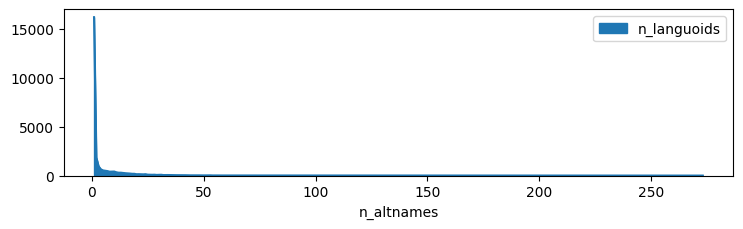

In [61]:
n_altnames = (sa.select(Languoid.id, sa.func.count().label('n_altnames'))
              .outerjoin_from(Languoid, Altname)
              .group_by(Languoid.id)
              .alias('languoid_naltnames')
              .c.n_altnames)

select_la_dist = (sa.select(n_altnames, sa.func.count().label('n_languoids'))
                  .group_by(n_altnames)
                  .order_by(n_altnames))

_ = read_sql(select_la_dist, index_col='n_altnames')

_.plot.area(figsize=(12 * 72 / 100, 3 * 72 / 100))

(read_sql(sa.select(sa.literal('n_altnames').label('value'),
                    sa.func.count().label('count'),
                    sa.func.sum(n_altnames).label('sum'),
                    sa.func.min(n_altnames).label('min'),
                    sa.func.max(n_altnames).label('max'),
                    sa.func.avg(n_altnames).label('mean')),
         index_col='value')
 .rename_axis(None))

## source

In [62]:
from treedb.models import Source, SourceProvider

select_provider_nsources = (sa.select(SourceProvider.name.label('provider'),
                                      Languoid.level,
                                      sa.func.count().label('n_sources'))
                            .join_from(SourceProvider, Source).join(Languoid)
                            .group_by(SourceProvider.name, Languoid.level)
                            .order_by('provider', sa.desc('n_sources')))

read_sql(select_provider_nsources, index_col=['provider', 'level'])

BEGIN (implicit)
SELECT sourceprovider.name AS provider, languoid.level, count(*) AS n_sources 
FROM sourceprovider JOIN source ON sourceprovider.id = source.provider_id JOIN languoid ON languoid.id = source.languoid_id GROUP BY sourceprovider.name, languoid.level ORDER BY provider, n_sources DESC
[generated in 0.00096s] ()
ROLLBACK


n_sources
provider  level              
glottolog language     215399
          dialect        2661
          family         2612

BEGIN (implicit)
SELECT lang_nsources.n_sources, count(*) AS n_languoids 
FROM (SELECT languoid.id AS id, count(source.languoid_id) AS n_sources 
FROM languoid LEFT OUTER JOIN source ON languoid.id = source.languoid_id GROUP BY languoid.id) AS lang_nsources GROUP BY lang_nsources.n_sources ORDER BY n_languoids
[generated in 0.00103s] ()
ROLLBACK
BEGIN (implicit)
SELECT ? AS value, count(*) AS count, sum(lang_nsources.n_sources) AS sum, min(lang_nsources.n_sources) AS min, max(lang_nsources.n_sources) AS max, avg(lang_nsources.n_sources) AS mean 
FROM (SELECT languoid.id AS id, count(source.languoid_id) AS n_sources 
FROM languoid LEFT OUTER JOIN source ON languoid.id = source.languoid_id GROUP BY languoid.id) AS lang_nsources
[generated in 0.00106s] ('n_sources',)
ROLLBACK


,count,sum,min,max,mean
n_sources,26953,220672,0,1565,8.187289


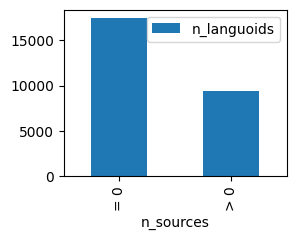

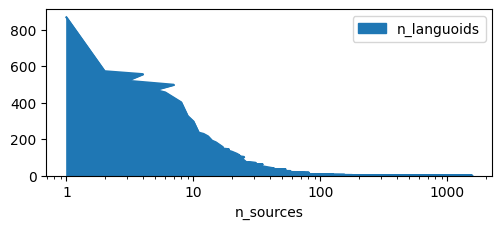

In [63]:
n_sources = (sa.select(Languoid.id,
                       sa.func.count(Source.languoid_id).label('n_sources'))
             .outerjoin_from(Languoid, Source)
             .group_by(Languoid.id)
             .alias('lang_nsources')
             .c.n_sources)

select_nsources_nlangs = (sa.select(n_sources, sa.func.count().label('n_languoids'))
                          .group_by(n_sources)
                          .order_by('n_languoids'))

_ = read_sql(select_nsources_nlangs, index_col='n_sources')
(_.groupby(_.index != 0).sum().rename_axis('n_sources')
    .rename(index={False: '= 0', True: '> 0'}).plot.bar(figsize=(4 * 72 / 100, 3 * 72 / 100)))
(_.drop(0).plot.area(figsize=(8 * 72 / 100, 3 *  72 / 100), logx=True)
    .xaxis.set_major_formatter(mpl.ticker.ScalarFormatter()))

(read_sql(sa.select(sa.literal('n_sources').label('value'),
                    sa.func.count().label('count'),
                    sa.func.sum(n_sources).label('sum'),
                    sa.func.min(n_sources).label('min'),
                    sa.func.max(n_sources).label('max'),
                    sa.func.avg(n_sources).label('mean')),
          index_col='value')
 .rename_axis(None))

BEGIN (implicit)
SELECT lang_nsources.level, lang_nsources.n_sources, count(*) AS n_languoids 
FROM (SELECT languoid.id AS id, languoid.level AS level, count(source.languoid_id) AS n_sources 
FROM languoid LEFT OUTER JOIN source ON languoid.id = source.languoid_id GROUP BY languoid.id, languoid.level) AS lang_nsources GROUP BY lang_nsources.level, lang_nsources.n_sources ORDER BY n_languoids
[generated in 0.00080s] ()
ROLLBACK


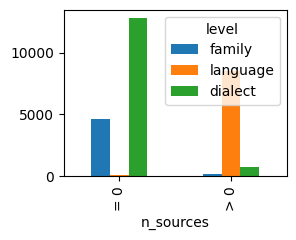

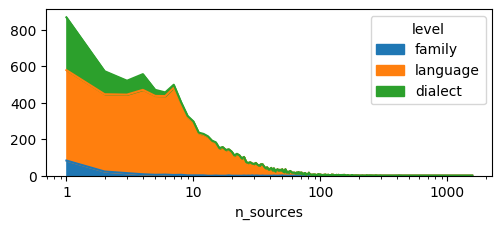

In [64]:
select_lang_nsources = (sa.select(Languoid.id, Languoid.level,
                                  sa.func.count(Source.languoid_id).label('n_sources'))
                        .outerjoin_from(Languoid, Source)
                        .group_by(Languoid.id, Languoid.level)
                        .alias('lang_nsources'))

select_ln_nlangs = (sa.select(select_lang_nsources.c.level,
                              select_lang_nsources.c.n_sources,
                              sa.func.count().label('n_languoids'))
                    .group_by(select_lang_nsources.c.level, select_lang_nsources.c.n_sources)
                    .order_by('n_languoids'))

_ = read_sql(select_ln_nlangs).pivot(index='n_sources', columns='level', values='n_languoids')
(_.groupby(_.index != 0).sum()[list(treedb.LEVEL)].rename_axis('n_sources')
 .rename(index={False: '= 0', True: '> 0'}).plot.bar(figsize=(4 * 72 / 100, 3 * 72 / 100)))
(_.drop(0)[list(treedb.LEVEL)].plot.area(figsize=(8 * 72 / 100, 3 * 72 / 100), logx=True)
 .xaxis.set_major_formatter(mpl.ticker.ScalarFormatter()))

BEGIN (implicit)
SELECT bibfile.name AS bibfile, count(*) AS n_used 
FROM bibfile JOIN bibitem ON bibfile.id = bibitem.bibfile_id GROUP BY bibfile.name ORDER BY n_used DESC
[generated in 0.00085s] ()
ROLLBACK


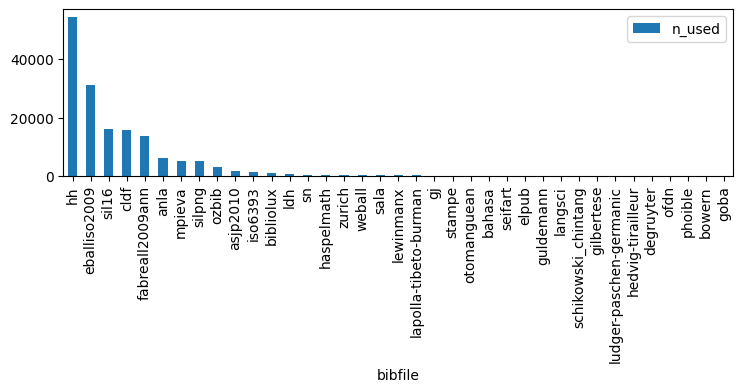

In [65]:
from treedb.models import Bibfile, Bibitem

select_bibfile_nused = (sa.select(Bibfile.name.label('bibfile'), sa.func.count().label('n_used'))
                        .join_from(Bibfile, Bibitem)
                        .group_by(Bibfile.name)
                        .order_by(sa.desc('n_used')))

(read_sql(select_bibfile_nused, index_col='bibfile')
 .plot.bar(figsize=(12 * 72 / 100, 3 * 72 / 100)));

## classification

In [66]:
from treedb.models import ClassificationRef

select_cr_levels = (sa.select(ClassificationRef.kind, Languoid.level,
                              sa.func.count().label('n_classificationrefs'))
                    .join_from(ClassificationRef, Languoid)
                    .group_by(ClassificationRef.kind, Languoid.level)
                    .order_by('kind', 'level'))

read_sql(select_cr_levels, index_col=['kind', 'level']).unstack()

BEGIN (implicit)
SELECT classificationref.kind, languoid.level, count(*) AS n_classificationrefs 
FROM classificationref JOIN languoid ON languoid.id = classificationref.languoid_id GROUP BY classificationref.kind, languoid.level ORDER BY classificationref.kind, languoid.level
[generated in 0.00078s] ()
ROLLBACK


n_classificationrefs                
level               dialect family language
kind                                       
family                    8    446      244
sub                     128   7008    11445

BEGIN (implicit)
SELECT lang_ncrefs.n_crefs, count(*) AS n_languoids 
FROM (SELECT languoid.id AS id, count(*) AS n_crefs 
FROM languoid LEFT OUTER JOIN classificationref ON languoid.id = classificationref.languoid_id GROUP BY languoid.id) AS lang_ncrefs GROUP BY lang_ncrefs.n_crefs ORDER BY lang_ncrefs.n_crefs
[generated in 0.00108s] ()
ROLLBACK
BEGIN (implicit)
SELECT ? AS value, count(*) AS count, sum(lang_ncrefs.n_crefs) AS sum, min(lang_ncrefs.n_crefs) AS min, max(lang_ncrefs.n_crefs) AS max, avg(lang_ncrefs.n_crefs) AS mean 
FROM (SELECT languoid.id AS id, count(*) AS n_crefs 
FROM languoid LEFT OUTER JOIN classificationref ON languoid.id = classificationref.languoid_id GROUP BY languoid.id) AS lang_ncrefs
[generated in 0.00080s] ('n_crefs',)
ROLLBACK


,count,sum,min,max,mean
n_crefs,26953,33661,1,16,1.248878


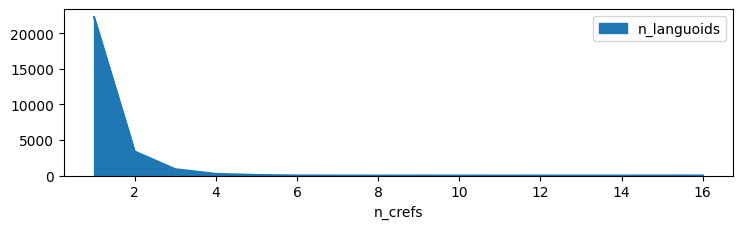

In [67]:
n_crefs = (sa.select(Languoid.id, sa.func.count().label('n_crefs'))
           .outerjoin_from(Languoid, ClassificationRef)
           .group_by(Languoid.id)
           .alias('lang_ncrefs')
           .c.n_crefs)

select_lcr_dist = (sa.select(n_crefs, sa.func.count().label('n_languoids'))
                   .group_by(n_crefs)
                   .order_by(n_crefs))

_ = read_sql(select_lcr_dist, index_col='n_crefs')

_.plot.area(figsize=(12 * 72 / 100, 3 * 72 / 100))

(read_sql(sa.select(sa.literal('n_crefs').label('value'),
                    sa.func.count().label('count'),
                    sa.func.sum(n_crefs).label('sum'),
                    sa.func.min(n_crefs).label('min'),
                    sa.func.max(n_crefs).label('max'),
                    sa.func.avg(n_crefs).label('mean')),
         index_col='value')
 .rename_axis(None))

## link

In [68]:
from treedb.models import Link

print_sql(Link)

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 8.31s ago] ('table', 'link')
SELECT count(*) AS n_rows 
FROM link
[generated in 0.00047s] ()
ROLLBACK


CREATE TABLE link (
	languoid_id VARCHAR(8) NOT NULL, 
	ord INTEGER NOT NULL CHECK (ord >= 1), 
	url TEXT NOT NULL CHECK (url != ''), 
	title TEXT CHECK (title != ''), 
	scheme TEXT, 
	PRIMARY KEY (languoid_id, ord), 
	UNIQUE (languoid_id, url), 
	CHECK (substr(url, 1, length(scheme) + 3) = scheme || '://'), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	CHECK (scheme IN ('http', 'https'))
) WITHOUT ROWID
32870


BEGIN (implicit)
SELECT link.scheme AS link_scheme, count(*) AS n_links 
FROM link GROUP BY link.scheme ORDER BY n_links DESC
[generated in 0.00093s] ()
ROLLBACK


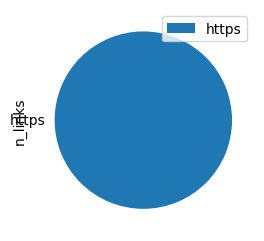

In [69]:
select_scheme_nlinks = (sa.select(Link.scheme.label('link_scheme'), sa.func.count().label('n_links'))
                        .group_by(Link.scheme)
                        .order_by(sa.desc('n_links')))

(read_sql(select_scheme_nlinks, index_col='link_scheme')
 .plot.pie(y='n_links', figsize=(6 * 72 / 100, 4 * 72 / 100)));

BEGIN (implicit)
SELECT link.url 
FROM link
[generated in 0.00087s] ()
ROLLBACK


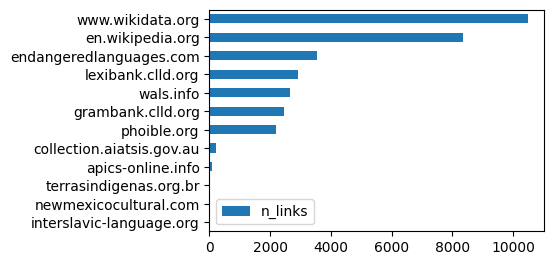

In [70]:
from urllib.parse import urlparse

hosts = collections.Counter(urlparse(url).hostname for url, in treedb.iterrows(sa.select(Link.url)))

(pd.DataFrame.from_dict(hosts, orient='index', columns=['n_links'])
 .sort_values(by='n_links')
 .plot.barh(figsize=(6 * 72 / 100, 4 * 72 / 100)));

## endangerment

In [71]:
from treedb.models import Endangerment, EndangermentStatus, EndangermentSource

print_sql(Endangerment)
print_sql(EndangermentStatus)
print_sql(EndangermentSource)
read_sql(sa.select(EndangermentStatus).order_by('ordinal'), index_col='config_section')

BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 8.676s ago] ('table', 'endangerment')
SELECT count(*) AS n_rows 
FROM endangerment
[generated in 0.00042s] ()
ROLLBACK


CREATE TABLE endangerment (
	languoid_id VARCHAR(8) NOT NULL, 
	status VARCHAR NOT NULL, 
	source_id INTEGER NOT NULL, 
	date DATETIME NOT NULL, 
	comment TEXT NOT NULL CHECK (comment != ''), 
	PRIMARY KEY (languoid_id), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	FOREIGN KEY(status) REFERENCES endangermentstatus (name), 
	FOREIGN KEY(source_id) REFERENCES endangermentsource (id)
) WITHOUT ROWID
8557


BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 8.682s ago] ('table', 'endangermentstatus')
SELECT count(*) AS n_rows 
FROM endangermentstatus
[generated in 0.00044s] ()
ROLLBACK


CREATE TABLE endangermentstatus (
	name VARCHAR NOT NULL CHECK (name != ''), 
	config_section VARCHAR NOT NULL CHECK (config_section != ''), 
	ordinal INTEGER NOT NULL CHECK (ordinal >= 1), 
	egids VARCHAR NOT NULL CHECK (egids != ''), 
	unesco VARCHAR NOT NULL CHECK (unesco != ''), 
	elcat VARCHAR NOT NULL CHECK (elcat != ''), 
	icon VARCHAR NOT NULL CHECK (icon != ''), 
	bibitem_id INTEGER, 
	PRIMARY KEY (name), 
	UNIQUE (config_section), 
	FOREIGN KEY(bibitem_id) REFERENCES bibitem (id)
) WITHOUT ROWID
6


BEGIN (implicit)
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 8.686s ago] ('table', 'endangermentsource')
SELECT count(*) AS n_rows 
FROM endangermentsource
[generated in 0.00052s] ()
ROLLBACK


CREATE TABLE endangermentsource (
	id INTEGER NOT NULL, 
	name TEXT NOT NULL CHECK (name != ''), 
	bibitem_id INTEGER, 
	pages TEXT CHECK (pages != ''), 
	PRIMARY KEY (id), 
	UNIQUE (bibitem_id, pages), 
	CHECK ((bibitem_id IS NULL) = (pages IS NULL)), 
	UNIQUE (name), 
	FOREIGN KEY(bibitem_id) REFERENCES bibitem (id)
)
65


BEGIN (implicit)
SELECT endangermentstatus.name, endangermentstatus.config_section, endangermentstatus.ordinal, endangermentstatus.egids, endangermentstatus.unesco, endangermentstatus.elcat, endangermentstatus.icon, endangermentstatus.bibitem_id 
FROM endangermentstatus ORDER BY endangermentstatus.ordinal
[generated in 0.00064s] ()
ROLLBACK


,name,ordinal,egids,unesco,elcat,icon,bibitem_id
config_section,,,,,,,
safe,not endangered,1,<=6a,safe,at risk/safe,ca2f49b,1
vulnerable,threatened,2,6b,vulnerable,vulnerable,cd5ce04,1
definite,shifting,3,7,definitely endangered,threatened/endangered,sf19903,1
severe,moribund,4,8a,severely endangered,severely endangered,df94902,1
critical,nearly extinct,5,8b,critically endangered,critically endangered,ta80003,1
extinct,extinct,6,>=9,extinct,dormant/awakening,f888888,1


BEGIN (implicit)
SELECT endangermentsource.name AS source, count(*) AS n_endangerments 
FROM endangerment JOIN endangermentsource ON endangermentsource.id = endangerment.source_id GROUP BY endangermentsource.name ORDER BY n_endangerments
[generated in 0.00087s] ()
ROLLBACK


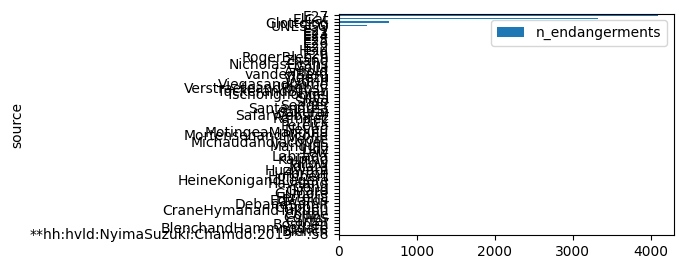

In [72]:
e_source = EndangermentSource.name.label('source')

select_source_nendangerments = (sa.select(e_source, sa.func.count().label('n_endangerments'))
                                .join_from(Endangerment, EndangermentSource)
                                .group_by(e_source)
                                .order_by('n_endangerments'))

(read_sql(select_source_nendangerments, index_col='source')
 .plot.barh(figsize=(6 * 72 / 100, 4 * 72 / 100)));

## Example query

In [73]:
%time treedb.hash_csv(treedb.get_example_query())

BEGIN (implicit)
WITH RECURSIVE tree(child_id, parent_id, steps, terminal) AS 
(SELECT child.id AS child_id, child.id AS parent_id, ? AS steps, child.parent_id IS NULL AS terminal 
FROM languoid AS child UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id, tree.steps + ? AS steps, grandparent.parent_id IS NULL AS terminal 
FROM tree JOIN languoid AS parent ON tree.parent_id = parent.id AND parent.parent_id IS NOT NULL LEFT OUTER JOIN languoid AS grandparent ON parent.parent_id = grandparent.id)
 SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, (SELECT group_concat(parent_path.path_part, ?) AS path 
FROM (SELECT tree.parent_id AS path_part 
FROM tree 
WHERE tree.child_id = languoid.id ORDER BY tree.steps DESC) AS parent_path) AS path, (SELECT tree.parent_id 
FROM tree 
WHERE tree.child_id = languoid.id AND tree.steps > ? AND tree.terminal = 1) AS family_id, (SELECT tree.parent_id 
FROM tree 
WHERE tree.child_id = languoid.id AND languoid.level

CPU times: total: 4.72 s
Wall time: 4.73 s


'c235e4b709b009a31f5a8eace0edeff02b08546f9f81b90139d017723fb4fa65'